# Generación de Texto usando un modelo Transformer
Basado en:

https://www.tensorflow.org/text/guide/subwords_tokenizer

https://www.tensorflow.org/text/tutorials/transformer


#0) Preparar ambiente:

In [1]:
#@title Oculta los warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

print("Warnings ocultos")

Warnings ocultos


In [2]:
#@title Instala paquete para procesamiento de Texto de TensorFlow
!pip install -U tensorflow-text


     |████████████████████████████████| 4.4 MB 5.4 MB/s 


1) Cargar las librerías:

In [3]:
#@title Librerías a usar
import tensorflow as tf
import numpy as np
import os
import csv

import pathlib
import matplotlib.pyplot as plt
import re

import tensorflow_text as tf_text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

print("Librerías cargadas")

Librerías cargadas


#2) Cargar el texto base a procesar:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/texto/'  #@param {type:"string"}

Mounted at /content/gdrive


In [5]:
nombre_archivo = "Cantata_del_adelantado_Don_Rodrigo_Diaz_de_Carreras.txt"  #@param {type:"string"}

# levanta el archivo de texto del Drive para procesar
text_cargado = open("".join([path, nombre_archivo]), 'rb').read().decode(encoding='utf-8', errors='ignore')

print("> Archivo cargado:")
print ('\n -- Tamaño total del texto: {} líneas'.format(len(text_cargado)))

# muestra los primeros 250 caracteres del texto
print("\n -- Ejemplo: \n", text_cargado[:250])

> Archivo cargado:

 -- Tamaño total del texto: 20630 líneas

 -- Ejemplo: 
 ﻿@SONG: Cantata del adelantado Don Rodrigo Diaz de Carreras...

[INTRODUCCIÓN]

Mastropiero era un apasionado de la investigación histórica.

Se pasaba largas horas en la biblioteca de la opulenta marquesa de
Quintanilla, cuyos volúmenes le ap


#3) Preparar el texto base a procesar:

In [6]:
#@title Limpiar el texto

sacar_caracteres_especiales = True #@param {type:"boolean"}
sacar_signos_puntuacion = True #@param {type:"boolean"}
sacar_otros_signos = True #@param {type:"boolean"}
sacar_acentos = True #@param {type:"boolean"}
pasar_minusculas = True 

# hace una copia por si se vuelve a ejecutar
texto = str(text_cargado)

# siempre saca símbolo de inicio
texto = texto.replace('\ufeff', ' ')

if sacar_caracteres_especiales:
  texto = texto.replace('\n', ' ') 
  texto = texto.replace('\t', ' ')
  texto = texto.replace('\r', ' ')   

if sacar_signos_puntuacion:
  texto = texto.replace(',', ' ')
  texto = texto.replace(';', ' ')
  texto = texto.replace('.', ' ')
  texto = texto.replace('¡', ' ')
  texto = texto.replace('¿', ' ')
  texto = texto.replace('!', ' ')
  texto = texto.replace('?', ' ')  

if sacar_otros_signos:
  texto = texto.replace('-', ' ')
  texto = texto.replace(':', ' ')
  texto = texto.replace('\'', ' ')
  texto = texto.replace('"', ' ')
  texto = texto.replace('“', ' ')
  texto = texto.replace('”', ' ')
  texto = texto.replace('`', ' ')
  texto = texto.replace('[', ' ')
  texto = texto.replace(']', ' ')
  texto = texto.replace('(', ' ')
  texto = texto.replace(')', ' ')
  texto = texto.replace('<', ' ')
  texto = texto.replace('>', ' ')
  texto = texto.replace('=', ' ')
  texto = texto.replace('/', ' ')
  texto = texto.replace('@', ' ')
  texto = texto.replace('~', ' ')
  texto = texto.replace('*', ' ')
  texto = texto.replace('_', ' ')

# pasa todo a minúsculas
if pasar_minusculas:
  texto = texto.lower()

# eliminar acentos (reemplaza por letra sin acento)
if sacar_acentos:
  texto = texto.replace('á', 'a')
  texto = texto.replace('é', 'e')
  texto = texto.replace('í', 'i')
  texto = texto.replace('ó', 'o')
  texto = texto.replace('ú', 'u')
  texto = texto.replace('Á', 'a')
  texto = texto.replace('É', 'e')
  texto = texto.replace('Í', 'i')
  texto = texto.replace('Ó', 'o')
  texto = texto.replace('Ú', 'u')

# saca todos los doble espacios (siempre)
texto = texto.replace('  ', ' ')
texto = texto.replace('  ', ' ')

print('\n -- Tamaño total del texto luego de la limpieza: {} caracteres'.format(len(texto)))
print("\n -- Ejemplo luego de la limpieza: \n", texto[:250])



 -- Tamaño total del texto luego de la limpieza: 18137 caracteres

 -- Ejemplo luego de la limpieza: 
  song cantata del adelantado don rodrigo diaz de carreras  introduccion  mastropiero era un apasionado de la investigacion historica  se pasaba largas horas en la biblioteca de la opulenta marquesa de quintanilla cuyos volumenes le apasionaban  alli 


In [7]:
#@title Armar secuencias de texto de Entrada/Salida

largo_secuencias = 25 #@param {type:"integer"}

# determinar el largo máximo de la secuencia
if ((len(texto)//largo_secuencias)<1000):
  seq_length = largo_secuencias//2
else:
  seq_length = largo_secuencias
examples_per_epoch = len(texto)//(seq_length+1)
print("Largo de secuencias: ", seq_length)
print("Ejemplos: ", examples_per_epoch)
print("\n")


# Dividir en datos de entrenamiento y prueba, para ello divide el texto en secuencias donde 
#- la secuencia de la posición 0 a [seq_length] se considera de entrada, y 
#- la secuencia de la posición [seq_length+1] al final es la de salida

# arma un data set auxiliar con el texto
texto_dataset = tf.data.Dataset.from_tensor_slices(texto.split(' '))

# filtra los elementos vacíos
texto_dataset = texto_dataset.filter(lambda x: x != b'')

# procesa para generar las secuencias del largo deseado
sequences = texto_dataset.batch(seq_length+1, drop_remainder=True)

# genera las secuencias de entrada y salida
def split_input_target(chunk):
  input_list = []
  target_list = []
  for i in range(len(chunk)-1):
    input_text = tf.strings.reduce_join(chunk[:i+1], separator=' ', axis=-1)
    target_text = tf.strings.reduce_join(chunk[i+1:], separator=' ', axis=-1)    
    input_list.append( input_text )
    target_list.append( target_text )
  return input_list, target_list

def split_input_target_old(chunk):
  input_text = tf.strings.reduce_join(chunk[:1], separator=' ', axis=-1)
  target_text = tf.strings.reduce_join(chunk[1:], separator=' ', axis=-1)    
  return input_text, target_text

datasetSeq = sequences.map(split_input_target)
datasetSeq = datasetSeq.flat_map(
    lambda x,y: tf.data.Dataset.from_tensor_slices( (x,y) ) 
    )  
print("\nDatasetSeq: ", datasetSeq, "\n")

print("\nEjemplos: ")
# muestra ejemplo
for input_example, target_example in datasetSeq.take(max(largo_secuencias,11)):
  print ('  Texto de Entrada: ', input_example.numpy())
  print ('  Texto de Salida:', target_example.numpy()) 
  print("\n")


Largo de secuencias:  12
Ejemplos:  1395



DatasetSeq:  <FlatMapDataset shapes: ((), ()), types: (tf.string, tf.string)> 


Ejemplos: 
  Texto de Entrada:  b'song'
  Texto de Salida: b'cantata del adelantado don rodrigo diaz de carreras introduccion mastropiero era un'


  Texto de Entrada:  b'song cantata'
  Texto de Salida: b'del adelantado don rodrigo diaz de carreras introduccion mastropiero era un'


  Texto de Entrada:  b'song cantata del'
  Texto de Salida: b'adelantado don rodrigo diaz de carreras introduccion mastropiero era un'


  Texto de Entrada:  b'song cantata del adelantado'
  Texto de Salida: b'don rodrigo diaz de carreras introduccion mastropiero era un'


  Texto de Entrada:  b'song cantata del adelantado don'
  Texto de Salida: b'rodrigo diaz de carreras introduccion mastropiero era un'


  Texto de Entrada:  b'song cantata del adelantado don rodrigo'
  Texto de Salida: b'diaz de carreras introduccion mastropiero era un'


  Texto de Entrada:  b'song cantata del ad

In [8]:
#@title Genera el Tokenizer

# Genera el vocabulario
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `tf_textBertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

# genera dataset de entrada y salida en base a las secuencias generadas
train_input = datasetSeq.map(lambda input, output: input)
train_output = datasetSeq.map(lambda input, output: output)

# aunque en este caso el vocabulario de entrada y salida debería ser igual
# genera dos para que sea más genérico
vocab_input = bert_vocab.bert_vocab_from_dataset(
    train_input.batch(1000).prefetch(2),
    **bert_vocab_args
)
vocab_output = bert_vocab.bert_vocab_from_dataset(
    train_output.batch(1000).prefetch(2),
    **bert_vocab_args
)
print("\n- Ejemplo Vocabulario: \n\t Input: ", vocab_input[:10], "\n\t Output: ", vocab_output[:10])

# genera archivos auxiliares con el vocabulario
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

pwd = pathlib.Path.cwd()
write_vocab_file('vocab_input.txt', vocab_input)
write_vocab_file('vocab_output.txt', vocab_output)


# funciones auxiliares
def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)
  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)
  return result

# clase Tokenizer
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = tf_text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

# Construye el tokenizador
# como instancias de la clase
tokenizers = tf.Module()
tokenizers.input = CustomTokenizer(reserved_tokens, 'vocab_input.txt')
tokenizers.output = CustomTokenizer(reserved_tokens, 'vocab_output.txt')

# muestra ejemplo de entrada y salida 
print("\n> Ejemplos: ")
i = 0 
for seqIn, seqOut in datasetSeq:
    print("Texto de Entrada:")
    print("--Original: ")
    print(" ", seqIn.numpy())
    print("--Tokenizado: ")
    tokIn = tokenizers.input.tokenize(seqIn)
    print("  ", tokIn.numpy())
    print("--Detokenizado: ")
    print(" ", tokenizers.input.detokenize(tokIn).numpy() )   
    print("\n") 
    print("Texto de Salida:")
    print("--Original: ")
    print(" ", seqOut.numpy())
    print("--Tokenizado: ")
    tokOut = tokenizers.output.tokenize(seqOut)
    print(" ", tokOut.numpy())
    print("--Detokenizado: ")
    print(" ", tokenizers.output.detokenize(tokOut).numpy() )   
    print("\n") 
    break
    


- Ejemplo Vocabulario: 
	 Input:  ['[PAD]', '[UNK]', '[START]', '[END]', '1', '4', '9', 'a', 'b', 'c'] 
	 Output:  ['[PAD]', '[UNK]', '[START]', '[END]', '1', '4', '9', 'a', 'b', 'c']

> Ejemplos: 
Texto de Entrada:
--Original: 
  b'song'
--Tokenizado: 
   [[  2 369   3]]
--Detokenizado: 
  [b'song']


Texto de Salida:
--Original: 
  b'cantata del adelantado don rodrigo diaz de carreras introduccion mastropiero era un'
--Tokenizado: 
  [[  2   9  70  66 108 108  44 150  58  51  93  33 137 625 667 301 131 412
  659 196 117 147  46   3]]
--Detokenizado: 
  [b'cantata del adelantado don rodrigo diaz de carreras introduccion mastropiero era un']




In [9]:
#@title Generar Datos de Entrenamiento

# define canalización de entrada
def tokenize_pairs(seq_input, seq_output):
    seq_input = tokenizers.input.tokenize(seq_input)
    # Convert from ragged to dense, padding with zeros.
    seq_input = seq_input.to_tensor()

    seq_output = tokenizers.output.tokenize(seq_output)
    # Convert from ragged to dense, padding with zeros.
    seq_output = seq_output.to_tensor()
    return seq_input, seq_output

BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(datasetSeq)
print("Train Batch: ", train_batches, "\n")



Train Batch:  <PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)> 



#4) Especificar y preparar el modelo Tranformer a usar:
*(todo este código es copiado del tutorial)*

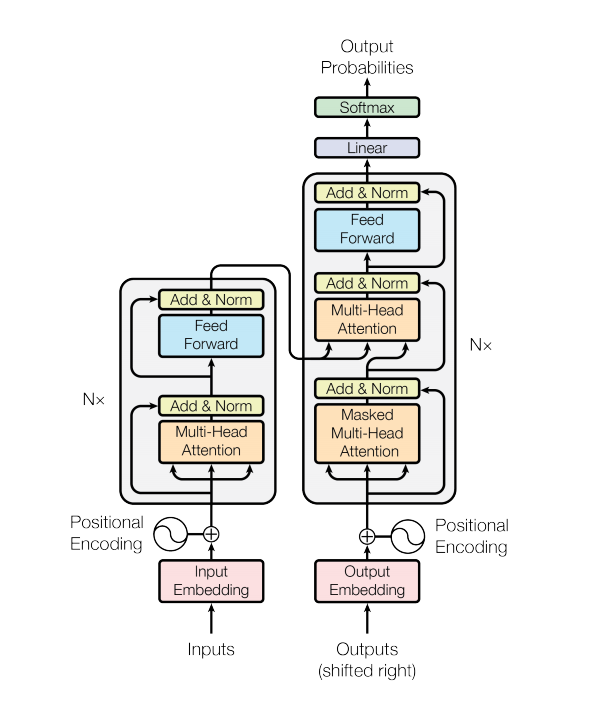

(1, 2048, 512)


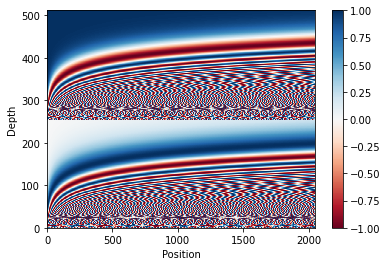

In [10]:
#@title Positional encoding

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()  

In [11]:
#@title Mask

def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [12]:
#@title Scaled dot product attention 

def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [13]:
#@title Multi-head attention 

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape    

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [14]:
#@title Point wise feed forward network 

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape  

TensorShape([64, 50, 512])

In [15]:
#@title Encoder Layer

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [16]:
#@title Decoder Layer

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [17]:
#@title Encoder 
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)    

(64, 62, 512)


In [18]:
#@title Decoder 
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [19]:
#@title Transformer

class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [20]:
#@title Hyper-Parameters

num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

print("Hyper-Parameters definidos")

Hyper-Parameters definidos


Text(0.5, 0, 'Train Step')

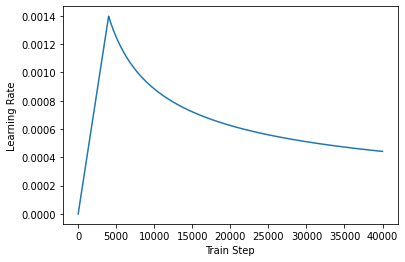

In [21]:
#@title Optimizer

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#learning_rate = CustomSchedule(d_model)
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [22]:
#@title Loss and metrics

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [23]:
#@title Inicializa el Transformer
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.input.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.output.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

print("Transformer inicializado: ", transformer)

Transformer inicializado:  <__main__.Transformer object at 0x7f7ee71d1fd0>


#5) Entrenar el Transformer:

In [24]:
#@title Preparar para el Entrenamiento

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))  

In [25]:
#@title Entrenar

import time

cant_epocas_entrenamiento =   100 #@param {type:"integer"}

history = [ [], [] ]

# ejecutar el entrenamiento
# se recomientda usar GPU
for epoch in range(cant_epocas_entrenamiento):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(train_batches):
    #if batch > 0: print(batch, end=" ")
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f' -Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      history[0].append( train_loss.result() )
      history[1].append( train_accuracy.result() )

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'   Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f' -Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
  history[0].append( train_loss.result() )
  history[1].append( train_accuracy.result() )

  print(f'   Time taken for epoch {epoch + 1}: {time.time() - start:.2f} secs\n')



 -Epoch 58 Loss 0.2790 Accuracy 0.9189
   Time taken for 1 epoch: 38.93 secs

 -Epoch 59 Batch 0 Loss 0.2421 Accuracy 0.9335
 -Epoch 59 Loss 0.2776 Accuracy 0.9191
   Time taken for 1 epoch: 39.05 secs

 -Epoch 60 Batch 0 Loss 0.2318 Accuracy 0.9305
   Saving checkpoint for epoch 60 at ./checkpoints/train/ckpt-12
 -Epoch 60 Loss 0.2823 Accuracy 0.9184
   Time taken for 1 epoch: 39.57 secs

 -Epoch 61 Batch 0 Loss 0.2374 Accuracy 0.9375
 -Epoch 61 Loss 0.2618 Accuracy 0.9236
   Time taken for 1 epoch: 39.69 secs

 -Epoch 62 Batch 0 Loss 0.2287 Accuracy 0.9343
 -Epoch 62 Loss 0.2539 Accuracy 0.9246
   Time taken for 1 epoch: 40.24 secs

 -Epoch 63 Batch 0 Loss 0.2105 Accuracy 0.9328
 -Epoch 63 Loss 0.2379 Accuracy 0.9292
   Time taken for 1 epoch: 40.52 secs

 -Epoch 64 Batch 0 Loss 0.2478 Accuracy 0.9311
 -Epoch 64 Loss 0.2547 Accuracy 0.9259
   Time taken for 1 epoch: 39.50 secs

 -Epoch 65 Batch 0 Loss 0.2293 Accuracy 0.9434
   Saving checkpoint for epoch 65 at ./checkpoints/train/ckp

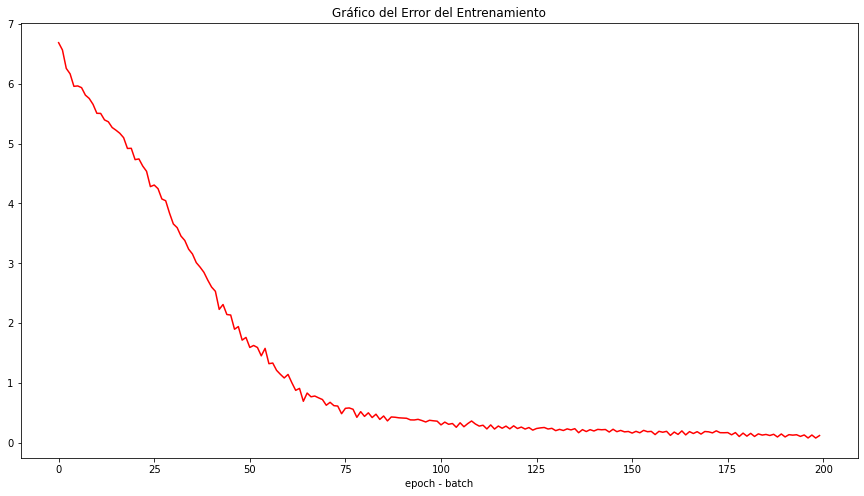

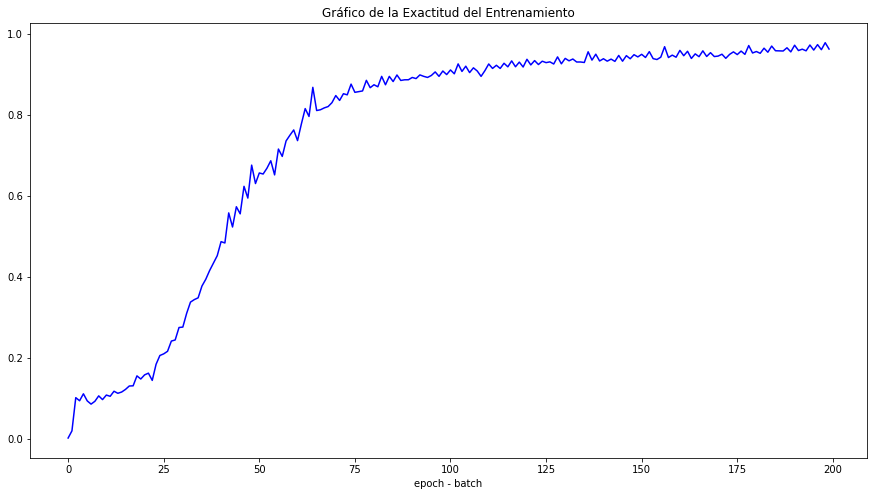

In [26]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history[0], color="red")
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch - batch')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history[1], color="blue")
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch - batch')
plt.show()

#6) Probar el Transformer entrenado:

In [27]:
#@title Prepara Generador de Texto

# Clase Generador de Texto
class BaseGeneradorTexto(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.input.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.output.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.output.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.output.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights


# Clase Wrapper generador texto
class GeneradorTexto(tf.Module):
  def __init__(self, generadorTexto):
    self.generadorTexto = generadorTexto

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, 
     tokens,
     attention_weights) = self.generadorTexto(sentence, max_length=100)

    return result, tokens, attention_weights

# funciones auxiliares
def plot_attention(generador, sentence, translated_tokens, attention_weights):    
    # convierte sentencia
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = generador.generadorTexto.tokenizers.input.tokenize(in_tokens).to_tensor()
    in_tokens = generador.generadorTexto.tokenizers.input.lookup(in_tokens)[0]
    in_tokens
    
    head = 0
    # shape: (batch=1, num_heads, seq_len_q, seq_len_k)
    attention_heads = tf.squeeze(attention_weights['decoder_layer4_block2'], 0)
    attention = attention_heads[head]
    #attention.shape

    # The plot is of the attention when a token was generated.
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(
        labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

def generarTexto(texto_entrada):
  # muestra entrada
  print("\n")
  print(f'{"-Entrada:":10s} {texto_entrada}')
  
  # llama al generador
  texto_entrada = tf.constant(texto_entrada)
  texto_salida, salida_tokens, attention_weights = gen(texto_entrada)

  # muestra resultados
  print(f'{"-Salida:":10s} {texto_salida.numpy()}')
  print("\n")
  plot_attention(gen, texto_entrada, salida_tokens, attention_weights)

print("\nGenerador de Texto definido.")


accion = "Grabar Modelo" #@param ["-", "Grabar Modelo", "Cargar Modelo"]
path_modelo = "/pruebaCantata" #@param {type:"string"}
dirModelo = path + path_modelo
dirModelo = dirModelo.replace("ARCHIVO", nombre_archivo)

# instancia el modelo
if accion == "Cargar Modelo":
  # Carga modelo exportador de texto
  gen = tf.saved_model.load(dirModelo)
  print("\nModelo cargado.")
else:
    # inicializa la clase
  gen = GeneradorTexto( BaseGeneradorTexto(tokenizers, transformer) )  
  print("\nModelo inicializado.")
  if accion == "Grabar Modelo":
    # Graba modelo exportador de texto
    tf.saved_model.save(gen, export_dir=dirModelo)
    print("\nModelo grabado.")



Generador de Texto definido.

Modelo inicializado.


INFO:tensorflow:Assets written to: gdrive/My Drive/IA/demoML/texto//pruebaCantata/assets


INFO:tensorflow:Assets written to: gdrive/My Drive/IA/demoML/texto//pruebaCantata/assets



Modelo grabado.




-Entrada:  de aqui
-Salida:   b'no me muevo uho de portacion de armas y fundacion ilicita'




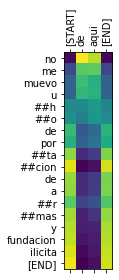

In [29]:
#@title Generar Texto 1

entrada_text = "de aqui" #@param {type:"string"}

generarTexto(entrada_text)




-Entrada:  el adelantado
-Salida:   b'don rodrigo hablo de don rodrigo diaz de carreras hijo de juana diaz y'




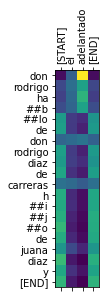

In [30]:
#@title Generar Texto 2

entrada_text = "el adelantado" #@param {type:"string"}

generarTexto(entrada_text)




-Entrada:  dsdasd
-Salida:   b'y lanza no eran del jefe afogutu eran de mi sobrino'




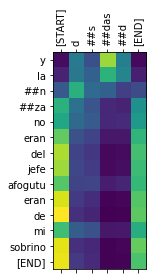

In [32]:
#@title Generar Texto 3

entrada_text = "dsdasd" #@param {type:"string"}

generarTexto(entrada_text)
